In [1]:
using LinearAlgebra, CairoMakie, SparseArrays;

In [2]:
struct HermiteBeam
    n_nodes_::Int
    n_elements_::Int
    x_mesh_::Vector{Float64}
    h_::Float64
    e_s_::Float64
    inertia_::Float64
    q_::Float64
end

function HermiteBeam(n_nodes::Int, x_0::Float64, beam_length::Float64, e_s::Float64, inertia::Float64, q::Float64)
    h = beam_length / (n_nodes - 1);
    x_mesh = Vector(LinRange(x_0, x_0 + beam_length, n_nodes));
    return HermiteBeam(n_nodes, n_nodes-1, x_mesh, h, e_s, inertia, q);
end

HermiteBeam

In [3]:
function generateBeamFEM(hermite_beams::Vector{HermiteBeam})
    n_nodes = sum([hermite_beam.n_nodes_ for hermite_beam in hermite_beams]);
    n_nodes -= length(hermite_beams) - 1;
    stiffness_matrix = spzeros(2*n_nodes, 2*n_nodes);
    source_vector = zeros(2*n_nodes);
    for (i_beam, beam) in enumerate(hermite_beams)
        start_node_id = sum([b.n_nodes_ for b in hermite_beams[1:i_beam-1]]) - (i_beam - 1);
        h = beam.h_;
        part_stiffness_matrix = [
            12/h^3 6/h^2 -12/h^3 6/h^2;
            6/h^2 4/h -6/h^2 2/h;
            -12/h^3 -6/h^2 12/h^3 -6/h^2;
            6/h^2 2/h -6/h^2 4/h
        ] * beam.e_s_ * beam.inertia_;
        part_source_vector = [h/2, h^2/12, h/2, -h^2/12] * beam.q_;
        # insert part stiffness matrix to stiffness matrix
        # and part source vector to source vector
        for i_element = 1: beam.n_elements_
            stiffness_matrix[
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2,
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2
            ] .+= part_stiffness_matrix;
            source_vector[
                2*start_node_id + 2*i_element - 1: 2*start_node_id + 2*i_element + 2
            ] .+= part_source_vector;
        end
    end
    return stiffness_matrix, source_vector;
end

generateBeamFEM (generic function with 1 method)

In [4]:
struct Problem
    e_s_::Vector{Float64}
    j_::Vector{Float64}
    l_::Vector{Float64}
    n_::Vector{Int}
    q_::Vector{Float64}
end

function generateHermiteBeams(problem::Problem)
    hermite_beams = HermiteBeam[];
    for i = 1: length(problem.e_s_)
        n = problem.n_[i];
        beam_length = problem.l_[i];
        start_x = sum(problem.l_[1:i]) - beam_length;
        e_s = problem.e_s_[i];
        inertia = problem.j_[i];
        q = problem.q_[i];
        hermite_beam = HermiteBeam(n, start_x, beam_length, e_s, inertia, q);
        push!(hermite_beams, hermite_beam);
    end
    return hermite_beams;
end

generateHermiteBeams (generic function with 1 method)

In [5]:
function knownNodes(problem::Problem)
    known_nodes_ids = [1, 2, 2*(sum(problem.n_) - length(problem.n_) + 1)-1, 2*(sum(problem.n_) - length(problem.n_) + 1)];
    known_nodes_values = [0., 0., 0., 0.];
    return known_nodes_ids, known_nodes_values;
end

knownNodes (generic function with 1 method)

In [6]:
function solve(
    stiffness_matrix::SparseMatrixCSC, 
    source_vector::Vector, 
    known_nodes_ids::Vector,
    known_nodes_values::Vector
)::Vector
    @assert length(known_nodes_ids) == length(known_nodes_values);
    n_nodes = length(source_vector);
    solution_vector = zeros(n_nodes);
    solution_vector[known_nodes_ids] .= known_nodes_values;
    unknown_nodes_ids = setdiff(1:n_nodes, known_nodes_ids);
    part_stiffness_matrix = stiffness_matrix[unknown_nodes_ids, unknown_nodes_ids];
    part_source_vector = (source_vector .- stiffness_matrix * solution_vector)[unknown_nodes_ids];
    solution_vector[unknown_nodes_ids] .= part_stiffness_matrix \ part_source_vector;
    return solution_vector;
end

solve (generic function with 1 method)

In [7]:
function solveProblem(problem::Problem)
    hermite_beams = generateHermiteBeams(problem);
    stiffness_matrix, source_vector = generateBeamFEM(hermite_beams);
    known_nodes_ids, known_nodes_values = knownNodes(problem);
    solution_vector = solve(stiffness_matrix, source_vector, known_nodes_ids, known_nodes_values);
    w = solution_vector[1:2:end];
    theta = solution_vector[2:2:end];
    return hermite_beams, w, theta;
end

solveProblem (generic function with 1 method)

In [8]:
function hermiteInterpolation(
    hermite_beams::Vector{HermiteBeam},
    ws::Vector,
    thetas::Vector,
    x::Float64
)
    for (i_beam, beam) in enumerate(hermite_beams)
        if x < beam.x_mesh_[1] || x > beam.x_mesh_[end]
            continue;
        else
            start_node_id = sum([b.n_nodes_ for b in hermite_beams[1:i_beam-1]]) - (i_beam - 1);
            w_beam = ws[start_node_id+1: start_node_id+beam.n_nodes_];
            theta_beam = thetas[start_node_id+1: start_node_id+beam.n_nodes_];
            if x in beam.x_mesh_
                index = findfirst(isequal(x), beam.x_mesh_);
                return w_beam[index], theta_beam[index];
            else
                index = findfirst(item->item > x, beam.x_mesh_);
                # if index == 1
                #     index = 2;
                # end
                index -= 1;
                x1 = beam.x_mesh_[index];
                t = x - x1;
                h = beam.h_;
                w_theta = [w_beam[index], theta_beam[index], w_beam[index+1], theta_beam[index+1]];
                coeff1 = [
                    (h-t)^2 * (h + 2*t), t * (h-t)^2 * h, t^2 * (3*h - 2*t), t^2 * (t-h) * h
                ] ./ h^3;
                coeff2 = [
                    6 * t * (t-h), (h - 3*t) * (h - t) * h, 6 * t * (h-t), t * (3*t - 2*h) * h
                ] ./ h^3;
                return dot(coeff1, w_theta), dot(coeff2, w_theta);
            end
        end
    end
    return 0., 0.;
end

function hermiteInterpolation(
    hermite_beams::Vector{HermiteBeam},
    ws::Vector,
    thetas::Vector,
    x_mesh_minor::Vector
)
    theta_minor = similar(x_mesh_minor);
    w_minor = similar(x_mesh_minor);
    for (i, x) in enumerate(x_mesh_minor)
        w_minor[i], theta_minor[i] = hermiteInterpolation(hermite_beams, ws, thetas, x);
    end
    return w_minor, theta_minor;
end

hermiteInterpolation (generic function with 2 methods)

In [9]:
function solveAndMinor(problem::Problem, x_minor::Vector)
    hermite_beams, w, theta = solveProblem(problem);
    w_minor, theta_minor = hermiteInterpolation(hermite_beams, w, theta, x_minor);
    return w_minor, theta_minor;
end

solveAndMinor (generic function with 1 method)

In [14]:
e_s = zeros(3) .+ 207e9;
j = [38.1e-3, 50.8e-3, 38.1e-3] .^4 .* pi ./ 64;
l = [0.15, 0.3, 0.15];
n1 = [2, 2, 2];
n2 = [2, 3, 2];
q = [0., -35e3, 0.];

problem_1 = Problem(e_s, j, l, n1, q);
problem_2 = Problem(e_s, j, l, n2, q);

x_minor = Vector(LinRange(0., sum(problem_1.l_), 101));
w_minor_1, theta_minor_1 = solveAndMinor(problem_1, x_minor);
w_minor_2, theta_minor_2 = solveAndMinor(problem_2, x_minor);

In [15]:
function analyticalAngle(x)
    out1 = ((x <= 0.15) ? (x .* (0.122599630386343 * x - 0.0257568362948163)) : (-0.0862028651153974 * x .^ 3 + 0.0775825786038577 * x .^ 2 - 0.013968317379196 * x - 0.000464459502472649))
    return out1
end

function analyticalDeflection(x)
    out1 = ((x <= 0.15) ? (x .^ 2 .* (0.0408665434621143 * x - 0.0128784181474081)) : (-0.0215507162788494 * x .^ 4 + 0.0258608595346192 * x .^ 3 - 0.00698415868959802 * x .^ 2 - 0.000464459502472649 * x - 1.39767905836677e-6))
    return out1
end

x_analytical = Vector(LinRange(0., sum(problem_1.l_)/2, 21));
w_analytical = analyticalDeflection.(x_analytical);
theta_analytical = analyticalAngle.(x_analytical);

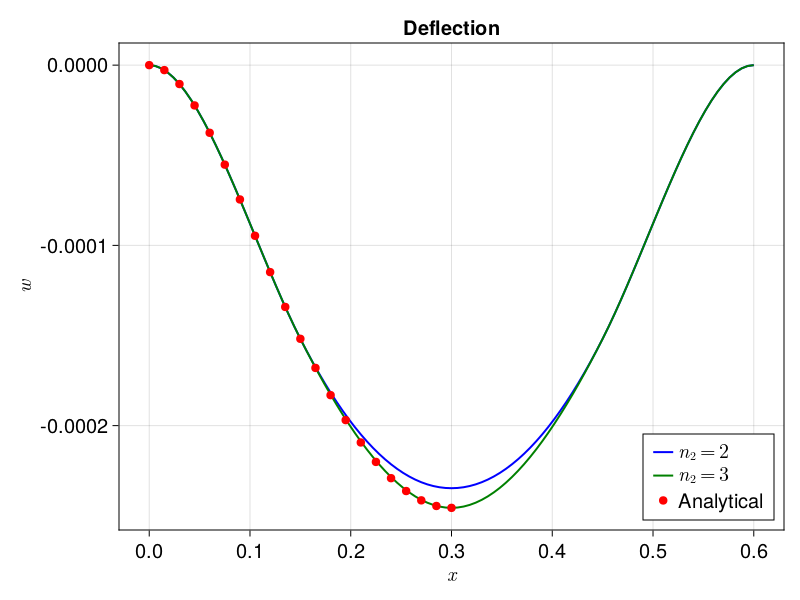

In [16]:
# w figure
fig_w = Figure(resolution = (800, 600), fontsize = 20);
axes_w = Axis(fig_w[1, 1], xlabel = L"$x$", ylabel = L"$w$", title = "Deflection");
lines!(axes_w, x_minor, w_minor_1, color = :blue, linewidth = 2, label = L"$n_2=2$");
lines!(axes_w, x_minor, w_minor_2, color = :green, linewidth = 2, label = L"$n_2=3$");
scatter!(axes_w, x_analytical, w_analytical, color = :red, linewidth = 2, label = "Analytical");
axislegend(axes_w, framevisible = true, position=:rb);
save("../images/deflection.pdf", fig_w, pt_per_unit = 0.7);
save("../images/deflection.png", fig_w);
fig_w

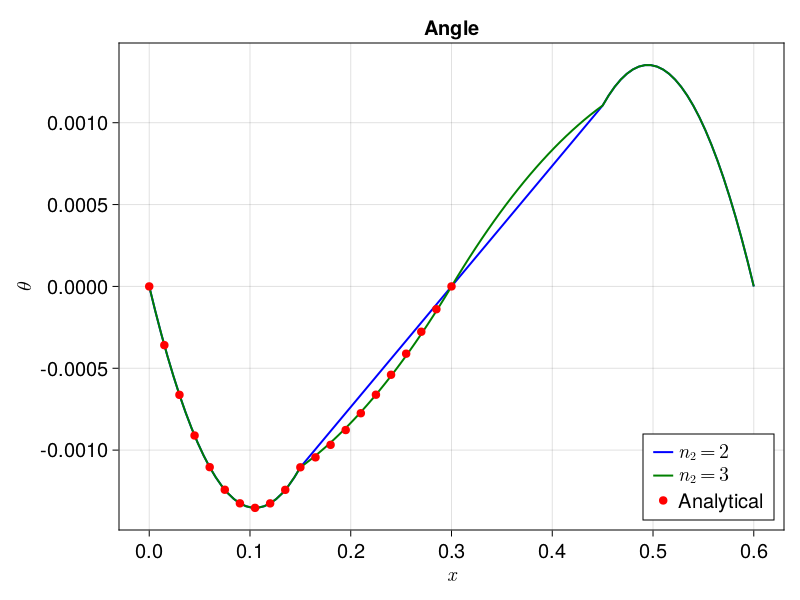

In [17]:
# theta figure
fig_theta = Figure(resolution = (800, 600), fontsize = 20);
axes_theta = Axis(fig_theta[1, 1], xlabel = L"$x$", ylabel = L"$\theta$", title = "Angle");
lines!(axes_theta, x_minor, theta_minor_1, color = :blue, linewidth = 2, label = L"$n_2=2$");
lines!(axes_theta, x_minor, theta_minor_2, color = :green, linewidth = 2, label = L"$n_2=3$");
scatter!(axes_theta, x_analytical, theta_analytical, color = :red, linewidth = 2, label = "Analytical");
axislegend(axes_theta, framevisible = true, position=:rb);
save("../images/angle.pdf", fig_theta, pt_per_unit = 0.7);
save("../images/angle.png", fig_theta);
fig_theta